# ImageJ: Thresholding

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Here, we will explore some ImageJ's methods to apply thresholds to images, generating binary images, labeled images and ROIs.
We will also confront some of the associated complications.

## Global thresholding

The main thresholding command in ImageJ is {menuselection}`Image --> Adjust --> Threshold...`, with the shortcut {kbd}`Shift + T`.

This opens a *Threshold* dialog that allows you to identify pixels above a threshold, below a threshold, or falling between two thresholds.
These options are controlled using a combination of the threshold sliders and the {guilabel}`Dark background` checkbox.
There is also a drop-down menu allowing you to select from a list of automated thresholding methods.

```{figure} images/imagej-thresholds-dialog.png
:align: center
:name: fig-thresholds_imagej_dialog
```

During preview, the pixels that are considered foreground are shown in red by default (it's possible to change this, but I never do).
After choosing suitable thresholds, pressing {guilabel}`Apply` produces a binary image.
This replaces the original, so it may be wise to duplicate the image first.

:::{admonition} Binary images in ImageJ
:class: info

Although only one 1 bit is really needed for each pixel in a binary image, the implementation in ImageJ currently uses 8 bits -- and so the actual pixel values allowed are 0 and 255.
To complicate matters, ImageJ also permits _either_ of these to represent the foreground, with the choice hidden away under {menuselection}`Process --> Binary --> Options...`, and 0 taken to be 'black' and 255 'white'.
Personally, I prefer for white to represent the foreground (i.e.
the interesting things we have detected), and so I will assume that the {guilabel}`Black background` option has been checked.

Nevertheless, you should be aware that this convention is not adopted universally.
Furthermore, if you choose {guilabel}`Invert LUT` then the colors are flipped anyway – so yet more confusion arises.
Therefore if you find that any processing of binary images gives odd results, be sure to check the binary options and LUT status.
:::

The *Threshold* dialog is good for interactively exploring different automated thresholding methods, but it can be hard to systematically compare them.
{menuselection}`Image --> Adjust --> Auto Threshold...` helps with this, by providing an option to try *all* of the methods.

```{figure} images/imagej-thresholds-all-dialog.png
:align: center
:name: fig-thresholds_imagej_all_dialog
```

Applying this to ImageJ's famous *blobs.gif* reveals that not all methods work equally well:

```{figure} images/imagej-thresholds-all-blobs.png
:align: center
:name: fig-thresholds_imagej_all_blobs
```

:::{admonition} Automated threshold methods
:class: tip
The various automated thresholds are described at https://imagej.net/Auto_Threshold, often with references to the original published papers upon which they are based.
:::

## Creating objects

Once we have a binary image, the next step is to identify objects for further exploration.

### Generating & measuring ROIs

ROIs are a good way to represent objects in ImageJ, because they are easy to measure.
In 2D, there are several options to generate ROIs from a thresholded image, each with slightly different applications:

* Click on an object with the *Wand tool* <img src="../../../images/imagej/icons/wand.png" /> -- this is good for interactively choosing one connected region.
* {menuselection}`Edit --> Selection --> Create Selection` -- this makes a single ROI containing all the foreground pixels.
Disconnected regions can be separated by adding the ROI to the *ROI Manager* and choosing {guilabel}`More >> Split`.
* {menuselection}`Analyze --> Analyze Particles...` -- this detects and measures all the foreground regions as individual objects, optionally filtering out objects based on shape or area.

:::{admonition} Creating ROIs without applying a threshold
:class: tip

The *Wand tool* <img src="../../../images/imagej/icons/wand.png" />, {menuselection}`Edit --> Selection --> Create Selection` & {menuselection}`Analyze --> Analyze Particles...` can also be used when a threshold is being previewed on an image, but it has not yet been converted to binary.
Therefore you may not need to press {guilabel}`Apply` in the *Threshold* dialog at all.

In fact, because it's not 100% clear whether black or white pixels represent the foreground in an ImageJ binary image, I tend to set a threshold even on an image that *is* already binary.
That way I can visualize what any of these commands will treat as foreground: with the default thresholding display, the foreground is highlighted in red.
:::

I like the fact that {menuselection}`Edit --> Selection --> Create Selection` provides a very quick way to convert a thresholded region to a single ROI.
I most often use it in combination with {menuselection}`Edit --> Selection --> Restore Selection` to visualize what has been detected on top of another image.
I might not necessarily *use* the single ROI for measurements in the end, but it can be very good for orientation.

When you want to measure multiple objects quickly, {menuselection}`Analyze --> Analyze Particles...` is arguably the most automated and versatile option.
Its various options also make it possible to ignore regions that are particularly small or large, straight or round (using a {guilabel}`Circularity` metric).
It can output summary results and add ROIs for each region to the *ROI Manager*.

```{figure} images/imagej-thresholds-analyze-dialog.png
:align: center
```


:::{admonition} Redirecting measurements
:class: info

Although binary images can show the shapes of things to be measured, pixel intensity measurements made on a binary image are not very helpful.
You could use the above techniques to make ROIs from binary images, then apply those to the original image to get meaningful measurements.

It's possible to do this by changing the {guilabel}`Redirect to:` option under {menuselection}`Analyze --> Set Measurements...`, which redirects measurements to be made on a specific image.
Setting a redirection image before running {menuselection}`Analyze --> Analyze Particles...` means that the ROI 'particles' can be detected on one image and measured on a different image

I don't usually recommend this, since I imagine I might forget to reset the {guilabel}`Redirect to:` option when I am done.
I'd rather add my ROIs to the *ROI Manager* and transfer them that way.

:::


::::{admonition} Caution with holey ROIs
:class: warning

Historically, there has been a problem with my preferred approach to use the *ROI Manager* output from {menuselection}`Analyze --> Analyze Particles...`.

It seems that {menuselection}`Analyze Particles...` handles holes correctly when making measurements by itself, but by default it would generate ROIs that lacked holes.
This meant that if you would measure the ROIs later you could get different results, because the ROIs included extra pixels that were actually excluded (as holes) in the thresholded image.

```{figure} images/imagej-thresholds-analyze-holes.png
:figwidth: 90%
:align: center

Different results when using {menuselection}`Analyze --> Analyze Particles...` directly, and then subsequently measuring the ROI that it generated. The image is binary, so the mean value should be 255 if only the above-threshold pixels are measured.
```

**However**, there is a solution -- which I only learned when writing about it here.
Since ImageJ v1.53g, there is a {guilabel}`Composite ROIs` checkbox when using {menuselection}`Analyze Particles...`.
If this is turned **on**, then ROIs with holes are generated as expected.

```{figure} images/imagej-thresholds-analyze-composite.png
:figwidth: 90%
:align: center

Fixing the problem with holey regions by using {guilabel}`Composite ROIs`.
```

This demonstrates the need to be cautious with any image analysis software, and to check out the various options associated with even common commands.
They aren't *always* doing what you might expect.

::::

### Generating labeled images

ROIs are not the only way to represent image objects: sometimes labeled images are more useful.

{menuselection}`Analyze --> Analyze Particles...` can generate labeled images by using the {guilabel}`Show: Count Masks` option.
This will generate a new image in which each pixel has a unique integer value indicating the number of the object it is part of -- or zero if it is in the background.
With a suitably colorful LUT (often {menuselection}`Image --> Lookup Tables --> Glasbey`), this can create a helpful and cheerful display of objects ({numref}`fig-blobs_binary_label`).

```{figure} images/imagej-thresholds-analyze-labels.png
:figwidth: 90%
:align: center

Creating a labeled image with {menuselection}`Analyze --> Analyze Particles`.
```

````{tabbed} Practical
:new-group:

[Connectivity](sec_thresholds_connectivity) (4 or 8) is an important consideration when converting a binary image to objects, since it can have a major impact on the number and size of objects.

Work out what kind of connectivity is used by
* {menuselection}`Analyze --> Analyze Particles...`
* the *Wand tool* <img src="../../../images/imagej/icons/wand.png" />

**Note:** You can investigate this by applying the commands/tools to a binary image that has some diagonally connected pixels.
One way to do this is by thresholding a suitable image, another is to use the *Brush tool* <img src="../../../images/imagej/icons/brush.png" /> to draw your own pixels in the binary image.

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/)

````

````{tabbed} Solution

At the time of writing, {menuselection}`Analyze --> Analyze Particles...` uses 8-connectivity.

For the *Wand tool* the right answer will depend upon the setting you see if you double-click the tool.
There are three options: 4-connectivity, 8-connectivity and 'legacy' (where 'legacy' seems to behave a bit like 8-connectivity).

```{image} images/imagej-thresholds-wand-dialog.png
:width: 40%
:align: center
```
````


## Local thresholding

A few methods to perform local thresholding can be found under {menuselection}`Image --> Adjust --> Auto Local Threshold`.
The dialog again provides the option to try all of them.

```{figure} images/imagej-thresholds-local-dialog.png
:align: center
:name: fig-thresholds_imagej_local_dialog
```

Using automated local filters is complicated by the fact that window sizes and parameters need to be tuned.
What these mean in each case is described at https://imagej.net/Auto_Local_Threshold

Currently, ImageJ's local thresholding also requires that the image is converted to 8-bit.
This should be done with some caution, since it can involve surreptitiously incorporating the [brightness & contrast settings](sec_bit_depths_converting) into the thresholding.

For these reasons, I tend to avoid local thresholding.



```{tabbed} Practical
:new-group:

Explore several automated methods of thresholding the different channels of {menuselection}`File --> Open samples --> HeLa Cells`, using both local and global automated thresholds, to draw your own conclusions about which methods you might prefer for different images.

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/?run=https://gist.github.com/petebankhead/a45e4eed3a90b6374ec7b272db090ec9)
```

## Addendum: Practical issues

We end this section with a brief discussion of a few non-obvious practical issues that impact thresholding, related to bit-depths and image types.

(sec_thresholding_nans)=
### Using NaNs

The first issue appears when you click {guilabel}`Apply` in the {menuselection}`Image --> Adjust --> Threshold...` dialog box for a 32-bit image.
This leads to a prompt asking whether to {guilabel}`Set Background Pixels to NaN`.

If this is chosen, a binary image is no longer created.
Instead, thresholding results in an image in which the foreground pixels retain their original values, while background pixels are **_NaN_**, or **_Not A Number_**.

*NaN* is a special value that can only be stored in floating point images, which ImageJ ignores when making measurements later.
It is therefore used to mask out regions, while preserving meaningful pixel values elsewhere.

This is an advanced option that is *potentially* useful, but can be a bit challenging to work with.
You have to be extra cautious when using an image containing NaNs, since some commands might behave in surprising ways.


```{tabbed} Practical
:new-group:

Create an image including NaN pixels, then measure some ROIs drawn on it.
Are area measurements affected by whether NaNs are present or not?

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/)
```


```{tabbed} Solution

They are!
If you measure the area of an image containing NaNs, the result is less than if you measure the area of the same image converted to 8-bit -- since only the non-NaN parts are included.
If you measure a region containing NaNs only, the area is 0.
```

```{tabbed} Question
:new-group:

Through experiment or guesswork, what do you suppose happens to NaNs with a 32-bit image is converted to 8-bit or 16-bit?
```

```{tabbed} Answer

Since NaN is not an integer, it cannot be stored in an 8-bit or 16-bit unsigned integer image.
Instead, all NaNs simply become zero.
```

### Histogram binning

The second way in which bit-depths and types matter is that histograms of images > 8-bit involve _binning_ the data.
For example, with a 32-bit image it would probably not make sense to create a histogram that has separate counts for all possible pixel values: in addition to counts for pixels with exact values 1 and 2, we would have thousands of counts for pixels with fractions in between and most of these counts would be 0.

Instead, the histogram is generated by dividing the total data range (maximum – minimum pixel values) into 256 separate _bins_ with equal widths, and counting how many pixels have values falling into the range of each bin.
It's therefore like a subtle conversion to 8-bit precision for the threshold calculation, but without actually changing the original data.
The same type of conversion is used for 16-bit images -- _unless_ you use the {menuselection}`Image --> Adjust --> Auto Threshold` command, which can use a full 16-bit histogram with 65536 bins.

This is where the {guilabel}`Don't reset range` option in ImageJ's thresholding dialog becomes relevant for 16-bit or 32-bit images, when used in combination with the {guilabel}`Auto` button.
* If {guilabel}`Don't reset range` **is selected**, then the binning uses the current minimum and maximum values in the brightness/contrast dialog
* If {guilabel}`Don't reset range` **is *not* selected**, then the binning *resets* the minimum and maximum values in the brightness/contrast dialog before using them

Personally, I find this confusing; I don't like the brighness/contrast impacting thresholds, and my poor brain even struggles to process the negative in the {guilabel}`Don't reset range` to get an intuitive feeling for what effect the option will really have.
And what makes things worse is that ImageJ's behavior in this regard has changed across versions, so there's a chance that any specific advice I give here won't match the version you're using anyway.

I know I'm not alone in being confused, since this has been the subject of a [long discussion on the image.sc forum](https://forum.image.sc/t/auto-threshold-calculation-and-bright-and-contrast-auto-adjust-issue/19301).
So the main message is: be aware that binning happens, and keep on the lookout for any unexpected effects that the brightness/contrast sliders might sneakily have on thresholding.

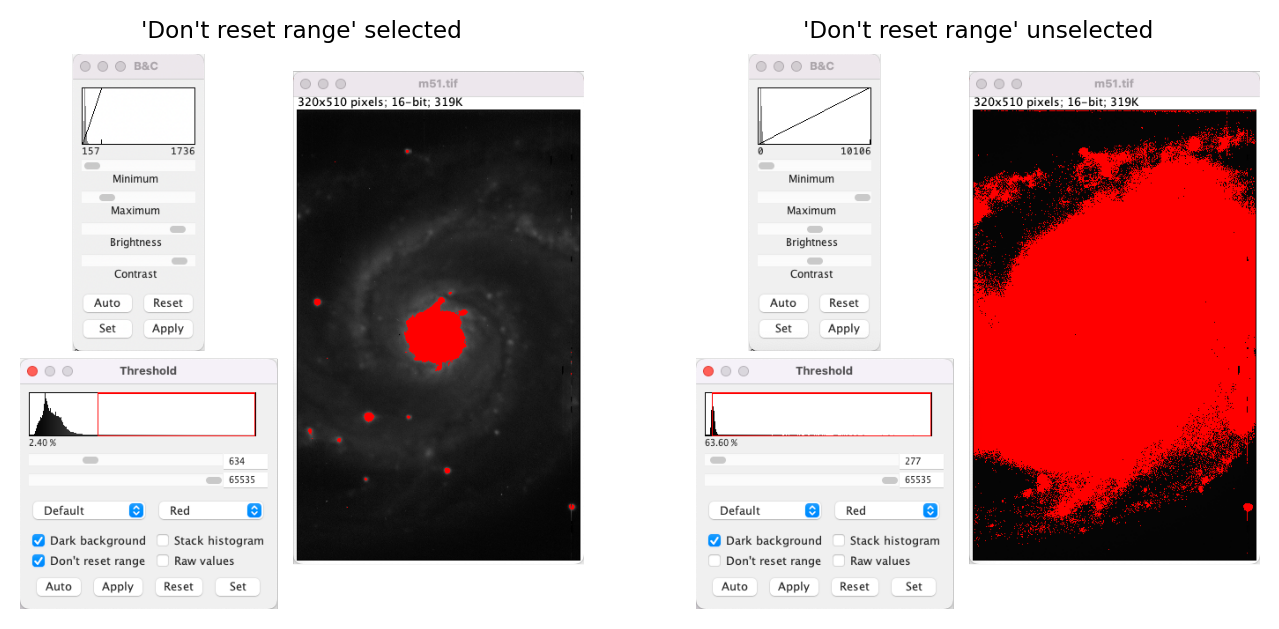

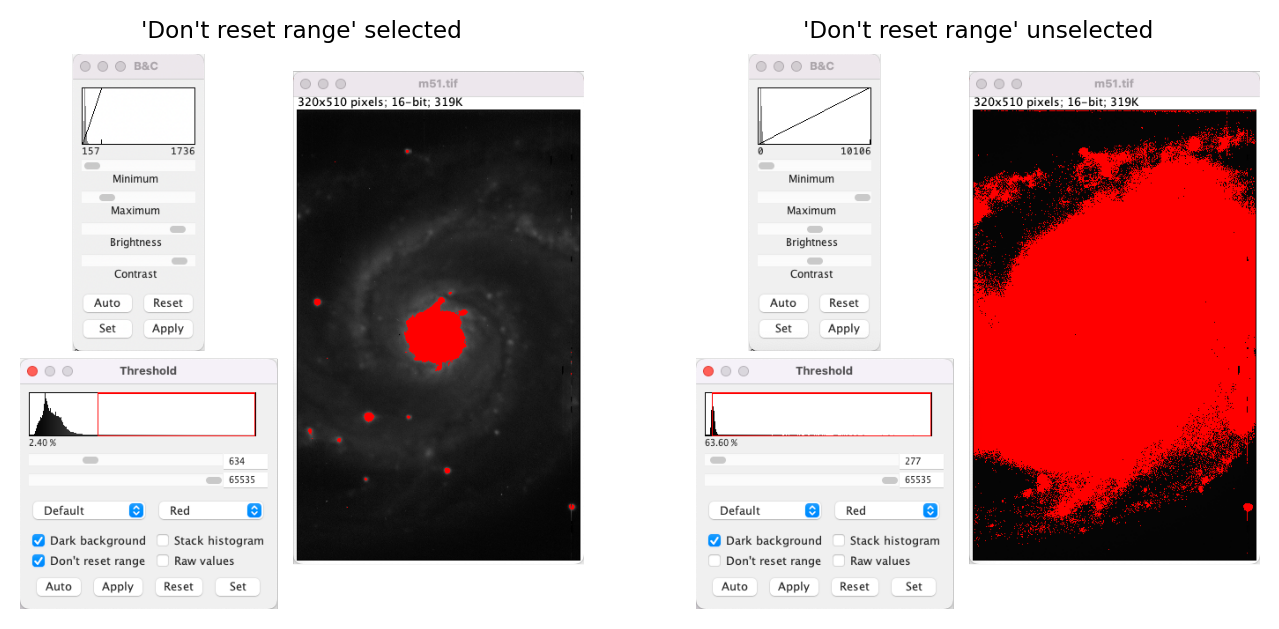

In [2]:
fig = create_figure(figsize=(8, 4))
show_image('images/imagej-m51-dont.png', title="'Don't reset range' selected", pos=121)
show_image('images/imagej-m51-do.png', title="'Don't reset range' unselected", pos=122)
glue_fig('fig_thresholds_range_reset', fig)

````{tabbed} Practical
:new-group:

Explore setting thresholds with and without {guilabel}`Don't reset range` selected for the image {menuselection}`File --> Open Samples --> M51 Galaxy (16-bits)`, and pressing the {guilabel}`Auto` button to determine a threshold.

Keep {menuselection}`Image --> Adjust --> Brightness/Contrast...` open as you explore, so you can make adjustments before calculating the thresholds.

```{figure} images/imagej-m51.png
:align: center
:figwidth: 25%
```

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/?run=https://gist.github.com/petebankhead/c5d2075777c458c70c69a1f2c8b37391)
````

````{tabbed} Solution

This image shows a potential use of the {guilabel}`Don't reset range` option -- used cautiously.

```{glue:figure} fig_thresholds_range_reset
---
align: center
---

Thresholding a 16-bit image with and without 'Don't reset range' selected.
```

````

```{tabbed} Practical
:new-group:

What are the implications of using a 256-bin histogram for thresholding a 32-bit image?

In particular, how might any outlier pixels affect the accuracy with which you can define a threshold -- automatically or manually?

To explore this, you can use the extreme example of *cell_outlier.tif* along with the {menuselection}`Image --> Adjust --> Threshold...` command.

How could you (manually) reduce the impact of any problems you find?

**Note:** {menuselection}`Analyze --> Histogram` lets you investigate the image histogram with different numbers of bins -- but any changes you make here will not be reflected in the histogram actually used for thresholding.

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/launch-imagej-js-badge.svg)](https://ij.imjoy.io?open=https://github.com/bioimagebook/practical-data/blob/main/images/cell_outlier.tif)

```


```{tabbed} Solution

First, a positive implication of using a 256-bit histogram for thresholding is that it can be fast: more bins add to the computations involved.
Also, creating too many bins has the result of making most of them zero -- potentially causing some automated threshold-determination algorithms to fail.

A negative implication is that using 256 bins means that only 256 different thresholds are possible: that is, if your image range is 0–25500, then the thresholds you could get are 0, 100, 200, ... 25500.
If the optimal threshold is really 150, this will not be found.
But usually if your range of pixel values is this large, you do not need a very fine-grained threshold for acceptable results anyway.

This changes if you have outliers.
A single extreme pixel -- which might occur when a pixel in a CCD camera is somehow 'broken' -- can cause most other pixels in the image to be squeezed into only a few bins.
Then the histogram resolution might really be too small for reasonable thresholding.

It's a sufficiently obscure problem that hopefully it won't bother you.
However, if you do experience the issue then two possible ways to overcome it are:

1. Adjust the brightness/contrast sliders and ensure that {guilabel}`Don't reset range` **is** selected. This is the benefit of the option existing.
2. Convert the image to 8-bit manually yourself. This allows you to effectively choose the range of the histogram bins (using {menuselection}`Brightness/Contrast...`; see {ref}`Types & bit-depths<sec_bit_depths_converting>`) Since the threshold is made using 256 bins, you are not really losing any information that was not going to be lost anyway.
```